# `pandas` performance comparison

In [55]:
import numpy as np
import pandas as pd

from urllib.request import urlopen
import json

from time import time
from datetime import datetime, timedelta

In [56]:
with urlopen('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv') as response:
    nyt_df = pd.read_csv(response, dtype={'fips':'str'})
nyt_df.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061,1,0
1,2020-01-22,Snohomish,Washington,53061,1,0
2,2020-01-23,Snohomish,Washington,53061,1,0
3,2020-01-24,Cook,Illinois,17031,1,0
4,2020-01-24,Snohomish,Washington,53061,1,0


In [57]:
nyt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340762 entries, 0 to 340761
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    340762 non-null  object
 1   county  340762 non-null  object
 2   state   340762 non-null  object
 3   fips    337294 non-null  object
 4   cases   340762 non-null  int64 
 5   deaths  340762 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 15.6+ MB


In [58]:
for col in nyt_df.select_dtypes(include='object').columns:
    print(col)
    print(len(nyt_df[col].unique()))
    print()

date
178

county
1901

state
55

fips
3168



- `fips` should not be numeric. As we'll see down below, we will have to import this as an object type so that we don't convert `float` values to `str`.
- the max for both `cases` and `deaths` is well below the maximum value of `int64`, so we can downcast.
- by nature of the data, the `state`-`county` combinations (and therefore `fips`) are far fewer than the number of entries in our dataset. We can change `state`, `county`, and `fips` to the `category` data type.
- we should probably change `date` into a `datetime` data type. This gives us some flexibility later.

**Why `category`?** The memory of the `object` data type is proportional to its length, whereas for `category` it is proportional to the number of categories plus the length. Given that we have 300k+ rows and only 1814 unique counties, we save memory when converting that column to `category`.

https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html#memory-usage

In [59]:
nyt_df['fips'] = nyt_df['fips'].astype('category')
nyt_df['cases'] = pd.to_numeric(nyt_df['cases'], downcast='integer')
nyt_df['deaths'] = pd.to_numeric(nyt_df['deaths'], downcast='integer')
nyt_df['state'] = nyt_df['state'].astype('category')
nyt_df['county'] = nyt_df['county'].astype('category')
nyt_df['date'] = pd.to_datetime(nyt_df['date'])
nyt_df.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061,1,0
1,2020-01-22,Snohomish,Washington,53061,1,0
2,2020-01-23,Snohomish,Washington,53061,1,0
3,2020-01-24,Cook,Illinois,17031,1,0
4,2020-01-24,Snohomish,Washington,53061,1,0


In [60]:
nyt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340762 entries, 0 to 340761
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    340762 non-null  datetime64[ns]
 1   county  340762 non-null  category      
 2   state   340762 non-null  category      
 3   fips    337294 non-null  category      
 4   cases   340762 non-null  int32         
 5   deaths  340762 non-null  int16         
dtypes: category(3), datetime64[ns](1), int16(1), int32(1)
memory usage: 6.5 MB


We reduce our memory usage by over half. While we were not using an absolute large amount of memory prior to optimization, it's good practice to optimize your code.

Combining into one function:

In [61]:
def optimize(df):
    '''
    Optimizes the data types in a pandas dataframe.
    '''
    dft = df.copy()
    # converts to datetime if possible
    dft = dft.apply(lambda col: pd.to_datetime(col, errors='ignore') if col.dtypes=='object' else col)
    # if there are less than half as many unique values as there are rows, convert to category
    for col in dft.select_dtypes(include='object'):
        if len(dft[col].unique()) / len(df[col]) < 0.5:
            dft[col] = dft[col].astype('category')
    # downcasts numeric columns if possible
    dft = dft.apply(lambda col: pd.to_numeric(col, downcast='integer') if col.dtypes=='int64' else col)
    dft = dft.apply(lambda col: pd.to_numeric(col, downcast='float') if col.dtypes=='float64' else col)
    return dft

In [62]:
with urlopen('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv') as response:
    nyt_df = optimize(pd.read_csv(response, dtype={'fips':'str'}))

nyt_df['fips'] = nyt_df['fips'].astype('object')
nyt_df.loc[nyt_df['county'] == 'New York City','fips'] = 'nyc'
nyt_df.loc[nyt_df['county'] == 'Kansas City','fips'] = 'kc'
nyt_df.loc[nyt_df['county'] == 'Joplin','fips'] = 'jm'
nyt_df['fips'] = nyt_df['fips'].astype('category')
nyt_df = nyt_df.dropna(axis=0)

pop_df = pd.read_csv('data/pop_df.csv')
# with urlopen('https://raw.githubusercontent.com/jydiw/nyt-covid-19-data/master/data/pop_df.csv') as response:
#     pop_df = optimize(pd.read_csv(response, dtype={'fips':'str'}))

In [63]:
nyt_df.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061,1,0
1,2020-01-22,Snohomish,Washington,53061,1,0
2,2020-01-23,Snohomish,Washington,53061,1,0
3,2020-01-24,Cook,Illinois,17031,1,0
4,2020-01-24,Snohomish,Washington,53061,1,0


In [64]:
pop_df.head()

,state,county,tot_pop,fips,area,lon,lat,pop_per_area,trump_pct
0,Alabama,Autauga,55869,01001,594.436,-86.641200,32.536150,93.986573,0.727666
1,Alabama,Baldwin,223234,01003,1589.784,-87.723950,30.725863,140.417813,0.765457
2,Alabama,Barbour,24686,01005,884.876,-85.389244,31.867890,27.897695,0.520967
3,Alabama,Bibb,22394,01007,622.582,-87.124960,32.996456,35.969561,0.764032
4,Alabama,Blount,57826,01009,644.776,-86.569756,33.985250,89.683859,0.893348


## `merge` and `join` performance considerations

`pandas` `merge()` is analogous to `SQL` `JOIN`.

We want to calculate ratios comparing the number of cases (or deaths) to the population and/or area of the county.

A naive solution would be to loop through each `fips` and perform operations that way.

In [65]:
print(nyt_df.shape)
print(pop_df.shape)

(337573, 6)
(3112, 9)


In [66]:
tick = time()

nyt_df1 = nyt_df.copy()
nyt_df1['cases_per_100k'] = 0
nyt_df1['deaths_per_100k'] = 0

count = 0
for fips in nyt_df1['fips'].unique():
    if fips in pop_df['fips'].values:
        nyt_df1.loc[nyt_df1['fips'] == fips, ['cases_per_100k', 'deaths_per_100k']] = nyt_df1.loc[nyt_df1['fips'] == fips, ['cases', 'deaths']] / pop_df.loc[pop_df['fips'] == fips, 'tot_pop'].tolist()[0]
        tock = time()
        count += 1
        if tock - tick >= 10:
            print(f'looped through {count} fips')
            break

print(tock - tick)

looped through 1317 fips
10.00626826286316


This takes a very long time. Instead, we can merge `nyt_df` and `pop_df`, then divide `cases` and `deaths` by the resulting `population` column.

In [67]:
tick = time()

df = nyt_df.merge(pop_df, on='fips', how='inner', suffixes=('_x','')).drop(['county_x', 'state_x'], axis=1)

# person density
df[['cases_per_100k', 'deaths_per_100k']] = df[['cases', 'deaths']].div(df['tot_pop'], axis=0) * 100_000

df = df.sort_values(by=['date', 'fips'])

tock = time()
print(tock - tick)
print(df.shape)
df.head()

0.22439956665039062
(329656, 14)


,date,fips,cases,deaths,state,county,tot_pop,area,lon,lat,pop_per_area,trump_pct,cases_per_100k,deaths_per_100k
0,2020-01-21,53061,1,0,Washington,Snohomish,822083,2087.273,-121.69278,48.046917,393.855054,0.374825,0.121642,0.0
1,2020-01-22,53061,1,0,Washington,Snohomish,822083,2087.273,-121.69278,48.046917,393.855054,0.374825,0.121642,0.0
2,2020-01-23,53061,1,0,Washington,Snohomish,822083,2087.273,-121.69278,48.046917,393.855054,0.374825,0.121642,0.0
178,2020-01-24,17031,1,0,Illinois,Cook,5150233,945.326,-87.81743,41.839622,5448.102624,0.209990,0.019417,0.0
3,2020-01-24,53061,1,0,Washington,Snohomish,822083,2087.273,-121.69278,48.046917,393.855054,0.374825,0.121642,0.0


`join` works similarly to merge, only the shared keys are the indices of each dataframe.

In [68]:
tick = time()

nyt_df1 = nyt_df.set_index(['fips', 'date'])
pop_df1 = pop_df.set_index('fips')

df1 = nyt_df1.join(pop_df1, on='fips', how='inner', lsuffix='_x', rsuffix='').drop(['county_x', 'state_x'], axis=1)
df1[['cases_per_100k', 'deaths_per_100k']] = df1[['cases', 'deaths']].div(df1['tot_pop'], axis=0) * 100_000
df1 = df1.sort_values(by=['date', 'fips'])

tock = time()
print(tock - tick)
print(df1.shape)
df1.head()

0.2211596965789795
(329656, 12)


cases  deaths       state     county  tot_pop      area  \
fips  date                                                                  
53061 2020-01-21      1       0  Washington  Snohomish   822083  2087.273   
      2020-01-22      1       0  Washington  Snohomish   822083  2087.273   
      2020-01-23      1       0  Washington  Snohomish   822083  2087.273   
17031 2020-01-24      1       0    Illinois       Cook  5150233   945.326   
53061 2020-01-24      1       0  Washington  Snohomish   822083  2087.273   

                        lon        lat  pop_per_area  trump_pct  \
fips  date                                                        
53061 2020-01-21 -121.69278  48.046917    393.855054   0.374825   
      2020-01-22 -121.69278  48.046917    393.855054   0.374825   
      2020-01-23 -121.69278  48.046917    393.855054   0.374825   
17031 2020-01-24  -87.81743  41.839622   5448.102624   0.209990   
53061 2020-01-24 -121.69278  48.046917    393.855054   0.374825   

                  cases_per_100k  deaths_per_100k  
fips  date                                         
53061 2020-01-21        0.121642              0.0  
      2020-01-22        0.121642              0.0  
      2020-01-23        0.121642              0.0  
17031 2020-01-24        0.019417              0.0  
53061 2020-01-24        0.121642              0.0

## `groupby` performance considerations

Looping through each column is very slow.

In [69]:
cols = ['cases', 'deaths', 'cases_per_100k', 'deaths_per_100k']

new_cols = ['new_' + c for c in cols]
delta_cols = ['delta_' + c for c in new_cols]

In [70]:
df2 = df.copy()

ding = time()

for i, col in enumerate(cols):
    print(col)
    tick = time()
    
    # new cases
    df2[new_cols[i]] = df2.groupby(by='fips')[col].diff().fillna(0)
    df2.loc[df2[new_cols[i]] < 0, new_cols[i]] = 0                # some counties revise their numbers
    
    # change in new cases
    df2[delta_cols[i]] = df2.groupby(by='fips')[new_cols[i]].diff().fillna(0)
    
    tock = time()
    print(tock - tick)
    print()
    
dong = time()
print(dong - ding)

df2.head()

cases
0.9085378646850586

deaths
0.9265873432159424

cases_per_100k
0.932567834854126

deaths_per_100k
0.9404857158660889

3.708178758621216


,date,fips,cases,deaths,state,county,tot_pop,area,lon,lat,...,cases_per_100k,deaths_per_100k,new_cases,delta_new_cases,new_deaths,delta_new_deaths,new_cases_per_100k,delta_new_cases_per_100k,new_deaths_per_100k,delta_new_deaths_per_100k
0,2020-01-21,53061,1,0,Washington,Snohomish,822083,2087.273,-121.69278,48.046917,...,0.121642,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-01-22,53061,1,0,Washington,Snohomish,822083,2087.273,-121.69278,48.046917,...,0.121642,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-01-23,53061,1,0,Washington,Snohomish,822083,2087.273,-121.69278,48.046917,...,0.121642,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
178,2020-01-24,17031,1,0,Illinois,Cook,5150233,945.326,-87.81743,41.839622,...,0.019417,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-01-24,53061,1,0,Washington,Snohomish,822083,2087.273,-121.69278,48.046917,...,0.121642,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`groupby.diff` performs rather slowly. The process is much faster when performing the tasks more explicitly. The following code was adapted from [this stackoverflow answer](https://stackoverflow.com/a/53159140).

In [72]:
df3 = df.copy()

ding = time()

# making new_cols
df3[new_cols] = df3[cols] - df3.groupby(by='fips')[cols].shift()
df3[new_cols] = df3[new_cols].fillna(0)
df3[new_cols] = df3[new_cols].clip(lower=0)

# making delta_cols
df3[delta_cols] = df3[new_cols] - df3.groupby(by='fips')[new_cols].shift()
df3[delta_cols] = df3[delta_cols].fillna(0)

# making new_cols_7d and delta_cols_7d
# df3[new_cols_7d] = df3.groupby(by='fips')[new_cols].apply(lambda x: x.rolling(7, min_periods=1).mean())
# df3[delta_cols_7d] = df3.groupby(by='fips')[delta_cols].apply(lambda x: x.rolling(7, min_periods=1).mean())

dong = time()
print(dong - ding)
df3.head()

0.21225905418395996


,date,fips,cases,deaths,state,county,tot_pop,area,lon,lat,...,cases_per_100k,deaths_per_100k,new_cases,new_deaths,new_cases_per_100k,new_deaths_per_100k,delta_new_cases,delta_new_deaths,delta_new_cases_per_100k,delta_new_deaths_per_100k
0,2020-01-21,53061,1,0,Washington,Snohomish,822083,2087.273,-121.69278,48.046917,...,0.121642,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-01-22,53061,1,0,Washington,Snohomish,822083,2087.273,-121.69278,48.046917,...,0.121642,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-01-23,53061,1,0,Washington,Snohomish,822083,2087.273,-121.69278,48.046917,...,0.121642,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
178,2020-01-24,17031,1,0,Illinois,Cook,5150233,945.326,-87.81743,41.839622,...,0.019417,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-01-24,53061,1,0,Washington,Snohomish,822083,2087.273,-121.69278,48.046917,...,0.121642,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [73]:
df2.sort_index(axis=1).equals(df3.sort_index(axis=1))

True

## using multi-indexed dataframe

In [74]:
df4 = df1.copy()
df4.head()

cases  deaths       state     county  tot_pop      area  \
fips  date                                                                  
53061 2020-01-21      1       0  Washington  Snohomish   822083  2087.273   
      2020-01-22      1       0  Washington  Snohomish   822083  2087.273   
      2020-01-23      1       0  Washington  Snohomish   822083  2087.273   
17031 2020-01-24      1       0    Illinois       Cook  5150233   945.326   
53061 2020-01-24      1       0  Washington  Snohomish   822083  2087.273   

                        lon        lat  pop_per_area  trump_pct  \
fips  date                                                        
53061 2020-01-21 -121.69278  48.046917    393.855054   0.374825   
      2020-01-22 -121.69278  48.046917    393.855054   0.374825   
      2020-01-23 -121.69278  48.046917    393.855054   0.374825   
17031 2020-01-24  -87.81743  41.839622   5448.102624   0.209990   
53061 2020-01-24 -121.69278  48.046917    393.855054   0.374825   

                  cases_per_100k  deaths_per_100k  
fips  date                                         
53061 2020-01-21        0.121642              0.0  
      2020-01-22        0.121642              0.0  
      2020-01-23        0.121642              0.0  
17031 2020-01-24        0.019417              0.0  
53061 2020-01-24        0.121642              0.0

In [75]:
df4 = df1.copy()

ding = time()

# making new_cols
grouped = df4.groupby(level=0)
df4[new_cols] = df4[cols] - grouped[cols].shift()
df4[new_cols] = df4[new_cols].fillna(0)
df4[new_cols] = df4[new_cols].clip(lower=0)

# making delta_cols
grouped = df4.groupby(level=0)
df4[delta_cols] = df4[new_cols] - grouped[new_cols].shift()
df4[delta_cols] = df4[delta_cols].fillna(0)

# making new_cols_7d and delta_cols_7d
# grouped = df4.groupby(level=0)
# df4[new_cols_7d] = grouped[new_cols].apply(lambda x: x.rolling(7, min_periods=1).mean())
# df4[delta_cols_7d] = grouped[delta_cols].apply(lambda x: x.rolling(7, min_periods=1).mean())

dong = time()
print(dong - ding)
df4.head()

0.1994645595550537


cases  deaths       state     county  tot_pop      area  \
fips  date                                                                  
53061 2020-01-21      1       0  Washington  Snohomish   822083  2087.273   
      2020-01-22      1       0  Washington  Snohomish   822083  2087.273   
      2020-01-23      1       0  Washington  Snohomish   822083  2087.273   
17031 2020-01-24      1       0    Illinois       Cook  5150233   945.326   
53061 2020-01-24      1       0  Washington  Snohomish   822083  2087.273   

                        lon        lat  pop_per_area  trump_pct  \
fips  date                                                        
53061 2020-01-21 -121.69278  48.046917    393.855054   0.374825   
      2020-01-22 -121.69278  48.046917    393.855054   0.374825   
      2020-01-23 -121.69278  48.046917    393.855054   0.374825   
17031 2020-01-24  -87.81743  41.839622   5448.102624   0.209990   
53061 2020-01-24 -121.69278  48.046917    393.855054   0.374825   

                  cases_per_100k  deaths_per_100k  new_cases  new_deaths  \
fips  date                                                                 
53061 2020-01-21        0.121642              0.0        0.0         0.0   
      2020-01-22        0.121642              0.0        0.0         0.0   
      2020-01-23        0.121642              0.0        0.0         0.0   
17031 2020-01-24        0.019417              0.0        0.0         0.0   
53061 2020-01-24        0.121642              0.0        0.0         0.0   

                  new_cases_per_100k  new_deaths_per_100k  delta_new_cases  \
fips  date                                                                   
53061 2020-01-21                 0.0                  0.0              0.0   
      2020-01-22                 0.0                  0.0              0.0   
      2020-01-23                 0.0                  0.0              0.0   
17031 2020-01-24                 0.0                  0.0              0.0   
53061 2020-01-24                 0.0                  0.0              0.0   

                  delta_new_deaths  delta_new_cases_per_100k  \
fips  date                                                     
53061 2020-01-21               0.0                       0.0   
      2020-01-22               0.0                       0.0   
      2020-01-23               0.0                       0.0   
17031 2020-01-24               0.0                       0.0   
53061 2020-01-24               0.0                       0.0   

                  delta_new_deaths_per_100k  
fips  date                                   
53061 2020-01-21                        0.0  
      2020-01-22                        0.0  
      2020-01-23                        0.0  
17031 2020-01-24                        0.0  
53061 2020-01-24                        0.0

## rolling average vs. rolling regression vs. Savitzky-Golay smoothing

In [97]:
import numpy.polynomial.polynomial as poly
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

### 7-day rolling average

In [86]:
cols_7a = [c + '_7a' for c in cols]
new_cols_7a = [c + '_7a' for c in new_cols]
delta_cols_7a = [c + '_7a' for c in delta_cols]

ca_df = df3[df3['state'] == 'California']
ca_df.head()

,date,fips,cases,deaths,state,county,tot_pop,area,lon,lat,...,cases_per_100k,deaths_per_100k,new_cases,new_deaths,new_cases_per_100k,new_deaths_per_100k,delta_new_cases,delta_new_deaths,delta_new_cases_per_100k,delta_new_deaths_per_100k
353,2020-01-25,06059,1,0,California,Orange,3175692,790.568,-117.757965,33.698452,...,0.031489,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
700,2020-01-26,06037,1,0,California,Los Angeles,10039107,4057.884,-118.216835,34.357796,...,0.009961,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
354,2020-01-26,06059,1,0,California,Orange,3175692,790.568,-117.757965,33.698452,...,0.031489,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
701,2020-01-27,06037,1,0,California,Los Angeles,10039107,4057.884,-118.216835,34.357796,...,0.009961,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
355,2020-01-27,06059,1,0,California,Orange,3175692,790.568,-117.757965,33.698452,...,0.031489,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [107]:
ca_df1 = ca_df.copy()

tick = time()
ca_df1[cols_7a] = ca_df1.groupby(by='fips')[cols].apply(lambda x: x.rolling(7, min_periods=1).mean())
ca_df1[new_cols_7a] = ca_df1.groupby(by='fips')[new_cols].apply(lambda x: x.rolling(7, min_periods=1).mean())
ca_df1[delta_cols_7a] = ca_df1.groupby(by='fips')[delta_cols].apply(lambda x: x.rolling(7, min_periods=1).mean())
tock = time()
print(tock - tick)

0.2044811248779297


### 7-day rolling regression

In [88]:
cols_7r = [c + '_7r' for c in cols]
new_cols_7r = [c + '_7r' for c in new_cols]
delta_cols_7r = [c + '_7r' for c in delta_cols]

In [94]:
ca_df2 = ca_df.copy()

tick = time()

# https://stackoverflow.com/a/34668038
d = dict.fromkeys(new_cols_7r, 0)
ca_df2 = ca_df2.assign(**d)

fips_list = ca_df2['fips'].unique()
for n, fips in enumerate(fips_list):
    dft = ca_df2[ca_df2['fips'] == fips][new_cols].values
    l = len(dft)
    preds = np.zeros((1, dft.shape[1]))        # first row of slopes is 0
    if l > 1:                                   # if we have more rows
        for i in range(2, np.min([l+1, 7])):
            x = np.arange(i)                    # emulating min_period=2
            y = dft[0:i]
            # https://stackoverflow.com/a/18767992
            coefs = poly.polyfit(x, y, 1)
            pred = [poly.polyval(x[-1], coefs)]
            preds = np.append(preds, pred, axis=0)
        if l > 7:
            x = np.arange(7)
            for j in range(7, l+1):
                y = dft[j-7:j]         # find slope of previous window
                coefs = poly.polyfit(x, y, 1)
                pred = [poly.polyval(x[-1], coefs)]
                preds = np.append(preds, pred, axis=0)
    if not (dft.shape == preds.shape):
        print(fips)
        break
    ca_df2.loc[ca_df2['fips'] == fips, new_cols_7r] = preds
    tock = time()
    if tock - tick >= 60:
        print(f'looped through {n} fips')
        break
print(tock - tick)

0.836972713470459


In [100]:
ca_df1['new_cases_7a'].sum() / ca_df1['new_cases'].sum()

0.9252794167862312

In [101]:
ca_df2['new_cases_7r'].sum() / ca_df1['new_cases'].sum()

0.9985854708753379

Rolling regression smoothes out the data more accurately. However, its calculation takes more than four times as long.

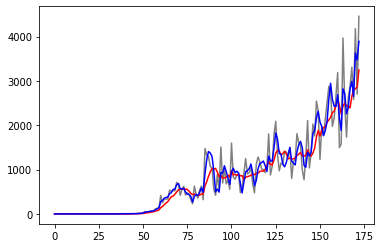

In [99]:
plt.plot(np.arange(len(ca_df1[ca_df1['county'] == 'Los Angeles'])), ca_df1[ca_df1['county'] == 'Los Angeles']['new_cases'], color='gray')
plt.plot(np.arange(len(ca_df1[ca_df1['county'] == 'Los Angeles'])), ca_df1[ca_df1['county'] == 'Los Angeles']['new_cases_7a'], color='red')
plt.plot(np.arange(len(ca_df1[ca_df1['county'] == 'Los Angeles'])), ca_df2[ca_df2['county'] == 'Los Angeles']['new_cases_7r'], color='blue')

### linear Savitzky-Golay smoothing with 7-day window

In [102]:
cols_7s = [c + '_7s' for c in cols]
new_cols_7s = [c + '_7s' for c in new_cols]
delta_cols_7s = [c + '_7s' for c in delta_cols]

In [108]:
ca_df3 = ca_df.copy()

tick = time()
ca_df3[cols_7s] = ca_df3.groupby(by='fips')[cols].transform(lambda x: savgol_filter(x, 7, 1))
ca_df3[new_cols_7s] = ca_df3.groupby(by='fips')[new_cols].transform(lambda x: savgol_filter(x, 7, 1))
ca_df3[delta_cols_7s] = ca_df3.groupby(by='fips')[delta_cols].transform(lambda x: savgol_filter(x, 7, 1))
tock = time()

print(tock - tick)

0.4667782783508301


In [110]:
ca_df3['new_cases_7s'].sum() / ca_df1['new_cases'].sum()

1.0013950281002713

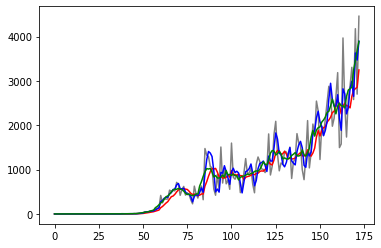

In [109]:
plt.plot(np.arange(len(ca_df1[ca_df1['county'] == 'Los Angeles'])), ca_df1[ca_df1['county'] == 'Los Angeles']['new_cases'], color='gray')
plt.plot(np.arange(len(ca_df1[ca_df1['county'] == 'Los Angeles'])), ca_df1[ca_df1['county'] == 'Los Angeles']['new_cases_7a'], color='red')
plt.plot(np.arange(len(ca_df1[ca_df1['county'] == 'Los Angeles'])), ca_df2[ca_df2['county'] == 'Los Angeles']['new_cases_7r'], color='blue')
plt.plot(np.arange(len(ca_df1[ca_df1['county'] == 'Los Angeles'])), ca_df3[ca_df2['county'] == 'Los Angeles']['new_cases_7s'], color='green')

Savitzky-Golay smoothing is twice as fast as rolling regression and still yields accurate results.